### The goal of this workbook is to set up a python script that can take in an initial position and velocity and predict it forwards for 24 hours. 


In [4]:
import sp3
import numpy as np
# import mu constnat from scipy
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
import orekit
from orekit.pyhelpers import setup_orekit_curdir
orekit.pyhelpers.download_orekit_data_curdir()
vm = orekit.initVM()
setup_orekit_curdir()
from Utilities import utc_to_jd 
from astropy import units
from datetime import datetime, timedelta
from org.orekit.frames import FramesFactory
from org.orekit.utils import PVCoordinates, IERSConventions
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.frames import ITRFVersion  
from orekit.pyhelpers import datetime_to_absolutedate

In [6]:
from astropy.coordinates import GCRS, ITRS
from astropy import units as u
from astropy.time import Time

# Load the sp3 file
product = sp3.Product.from_file(r'C:\Users\IT\Documents\UCL\CatAnalysis\RawData\v1\GFZOP_RSO_L64_G_20230924_100000_20230925_000000_v03.sp3')

start = product.satellites[0].records[0]
end = product.satellites[0].records[-1]

# Convert the time to a Time object
time = Time(start.time, scale='utc')
print(time)

grace_itrf = ITRS(x=start.position[0]*u.m, y=start.position[1]*u.m, z=start.position[2]*u.m, 
                v_x=start.velocity[0]*u.m/u.s, v_y=start.velocity[1]*u.m/u.s, v_z=start.velocity[2]*u.m/u.s,
                obstime = time, representation_type='cartesian', differential_type='cartesian')
grace_ecef = grace_itrf.transform_to(GCRS(obstime=time))
print(grace_ecef.cartesian.differentials)
print(grace_ecef.cartesian.xyz)
print(grace_ecef.velocity)

2023-09-24 09:59:42
{'s': <CartesianDifferential (d_x, d_y, d_z) in km / s
    (-6.89059495, 3.17181365, 0.80474743)>}
[ 703531.3658096  -182830.81377252 6811753.86421208] m
(-6.89059495, 3.17181365, 0.80474743) km / s


In [7]:
def gravitational_acceleration(position):
    # This will take in a position of the satellite and calculate the gravitational acceleration
    # Distance from the Earth's Center
    r = np.linalg.norm(position)
    r_hat = position / r
    mu = 3.986004418e14
    acceleration = -mu / r**2 * r_hat
    return acceleration

def update_satellite(position, velocity, dt):
    # Calculat the acceleratoin due to gravity
    acceleration = gravitational_acceleration(position)

    # Update the velocity
    new_velocity = velocity + acceleration * dt

    new_position = position + new_velocity * dt

    return new_position, new_velocity

print(f"The satellite starts with a position of: {start.position} m \n and a velocity of: {start.velocity} m/s")

dt = 60

# get the grace data in a slightly better format
position = np.array(grace_ecef.cartesian.xyz.to(u.m).value)
velocity = np.array(grace_ecef.velocity.d_xyz.to(u.m/u.s).value)

positions = [position]
velocities = [velocity]
# time loop for 24 hours
for i in range (int(24*3600/dt)):
    # Need to make sure you update the satellites pos and vel from the last time
    position, velocity = update_satellite(position, velocity, dt)
    positions.append(position)
    velocities.append(velocity)

print(positions[0:5])
print(velocities[0:5])


The satellite starts with a position of: (-695003.242, -153994.685, 6813342.082) m 
 and a velocity of: (7567.655819700001, 405.9447149, 789.0613869) m/s
[array([ 703531.3658096 , -182830.81377252, 6811753.86421208]), array([ 286955.37381613,    8294.09187413, 6829633.64352069]), array([-130909.79485252,  199381.73545579, 6816830.58780771]), array([-548183.03690564,  389567.84713907, 6773204.29642208]), array([-962961.72669241,  577981.19810094, 6698755.97846778])]
[array([-6890.59494623,  3171.8136458 ,   804.74743335]), array([-6942.93319989,  3185.41509411,   297.99632181]), array([-6964.41947781,  3184.79405969,  -213.38426188]), array([-6954.55403422,  3169.76852805,  -727.10485643]), array([-6912.97816311,  3140.22251603, -1240.80529924])]


In [10]:
# Create a list of times, by adding the time delta to the start time




[<Time object: scale='utc' format='datetime' value=2023-09-24 09:59:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:00:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:01:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:02:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:03:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:04:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:05:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:06:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:07:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:08:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:09:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:10:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10:11:42>, <Time object: scale='utc' format='datetime' value=2023-09-24 10

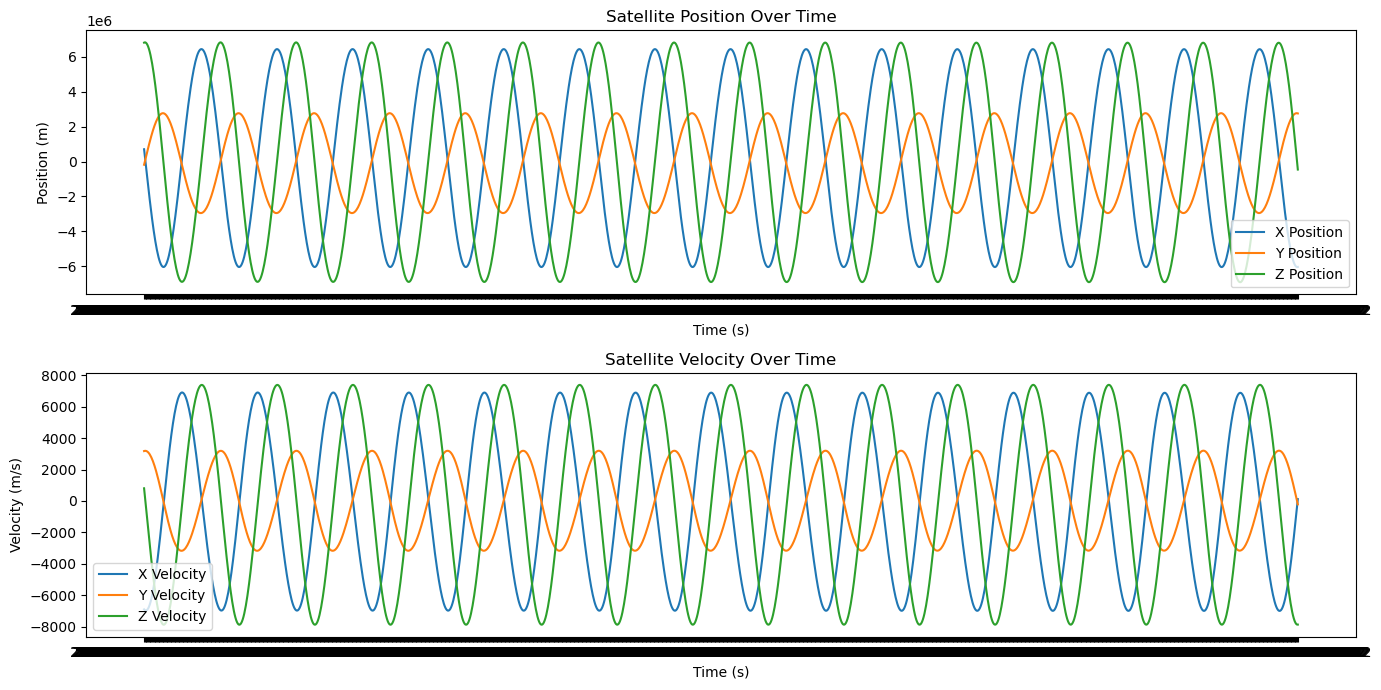

In [16]:
# Define the time steps
times = [time]
for i in range(1, len(positions)):
    times.append(times[-1] + timedelta(seconds=dt))

# convert dates to string for plotting
times = [str(t) for t in times]

# Plot the positions
plt.figure(figsize=(14, 7))

# Plot X, Y, Z positions over time
plt.subplot(2, 1, 1)
plt.plot(times, [pos[0] for pos in positions], label='X Position')
plt.plot(times, [pos[1] for pos in positions], label='Y Position')
plt.plot(times, [pos[2] for pos in positions], label='Z Position')
plt.title('Satellite Position Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()

# Plot X, Y, Z velocities over time
plt.subplot(2, 1, 2)
plt.plot(times, [vel[0] for vel in velocities], label='X Velocity')
plt.plot(times, [vel[1] for vel in velocities], label='Y Velocity')
plt.plot(times, [vel[2] for vel in velocities], label='Z Velocity')
plt.title('Satellite Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.show()